<img src="https://cdn1.byjus.com/wp-content/uploads/blog/2021/01/21071038/giphy-1.gif" alt="Ship on waves gif"></img>

# Great Circles and Parallels

---

## Overview

As a great circle path traverses around the globe, it will eventually hit a maximum or minimum latitude (unless it is a great circlea around the equator which will never vary in latitude). For this notebook, we will learn how to determine the position for the maximum and minimum positions along the globe as well as how to determine where (and if) a point crosses a specific parallel.

1. Determine the maximum latitude on a Great Circle Path
1. Determine the minimum latitude on a Great Great path

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | Used to work with large arrays |
| [Pandas](https://foundations.projectpythia.org/core/pandas) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy) | Helpful | Will be used for adding maps to plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

- Import Packages
- Setup location dataframe with coordinates

In [1]:
import pandas as pd       # reading in data for location information from text file
import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [2]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [3]:
location_df.index = location_df["name"]

## Maximum Latitude on a Great Circle Path

We have previously determined an equation to derive a great circle path from intermediate points from two points on a great circle arc. Without additional calculations, we can use a list of points along the great circle path to find the maximum location of the maximum and minimum. It will simply be when the latitude is either at its maximum and minimum.

By default, the equation below will determine 360 points along longitude, so the output will only have a resolution of 1 degree. However, by defining the longitude with more points, the resolution increases.

In [6]:
# See Previous Notebook to see how we generate a list of latitude/longtiude points for a great circle path

def generate_latitude_along_gc(start_point=None, end_point=None, number_of_lon_pts=360):
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])

    # Verify not meridian (longitude passes through the poles)
    if np.sin(lon1 - lon2) == 0:
        print("Invalid inputs: start/end points are meridians")
        # plotting meridians at 0 longitude through all latitudes
        meridian_lat = np.arange(-90, 90, 180/len(longitude_lst)) # split in n number
        meridians = []
        for lat in meridian_lat:
            meridians.append((lat, 0))
        return meridians

    # verify not anitpodal (diametrically opposite, points)
    if lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi:
        print("Invalid inputs: start/end points are antipodal")
        return []

    # generate n total number of longitude points along the great circle
    # https://github.com/rspatial/geosphere/blob/master/R/greatCircle.R#L18C3-L18C7
    gc_lon_lst = []
    for lon in range(1, number_of_lon_pts+1):
        new_lon = (lon  * (360/number_of_lon_pts) - 180)
        gc_lon_lst.append(np.deg2rad(new_lon))

    # Intermediate points on a great circle: https://edwilliams.org/avform147.htm"
    gc_lat_lon = []
    for gc_lon in gc_lon_lst:
        num = np.sin(lat1)*np.cos(lat2)*np.sin(gc_lon-lon2)-np.sin(lat2)*np.cos(lat1)*np.sin(gc_lon-lon1)
        den = np.cos(lat1)*np.cos(lat2)*np.sin(lon1-lon2)
        new_lat = np.arctan(num/den)
        gc_lat_lon.append((float(np.rad2deg(new_lat)), float(np.rad2deg(gc_lon))))
    return gc_lat_lon

In [8]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=360)
print(f"Max Latitude Position (within 1 degree): {max(lat_lon, key=lambda x:x[0])}")

Max Latitude Position (within 1 degree): (42.750406941471915, -81.0)


In [9]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=720)
print(f"Max Latitude Position (within 0.5 degree): {max(lat_lon, key=lambda x:x[0])}")

Max Latitude Position (within 0.5 degree): (42.751388471834524, -80.5)


In [10]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=1080)
print(f"Max Latitude Position (within 0.3 degree): {max(lat_lon, key=lambda x:x[0])}")

Max Latitude Position (within 0.3 degree): (42.751302958796096, -80.66666666666667)


### Plot Maximum

Let's see this on a map. Let's plot the maximum point along a great circle path:

In [12]:
def plot_coordinate_max_min(great_circle_pts=None,
                            max_coord=None, min_coord=None,
                            title=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -180, 180, -90, 90
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")
    
    # Plot Great Circle Latitude/Longitude Location
    longitudes = [x[1] for x in great_circle_pts] # longitude
    latitudes = [x[0] for x in great_circle_pts] # latitude
    plt.plot(longitudes, latitudes)

    # Overly Max/Min Coordinates
    if max_coord is not None:
        plt.scatter([max_coord[1]], [max_coord[0]], s=100, c="red")
    if min_coord is not None:
        plt.scatter([min_coord[1]], [min_coord[0]], s=100, c="green")
    
    # Setup Axis Limits and Title/Labels
    plt.title(title)
    plt.show()

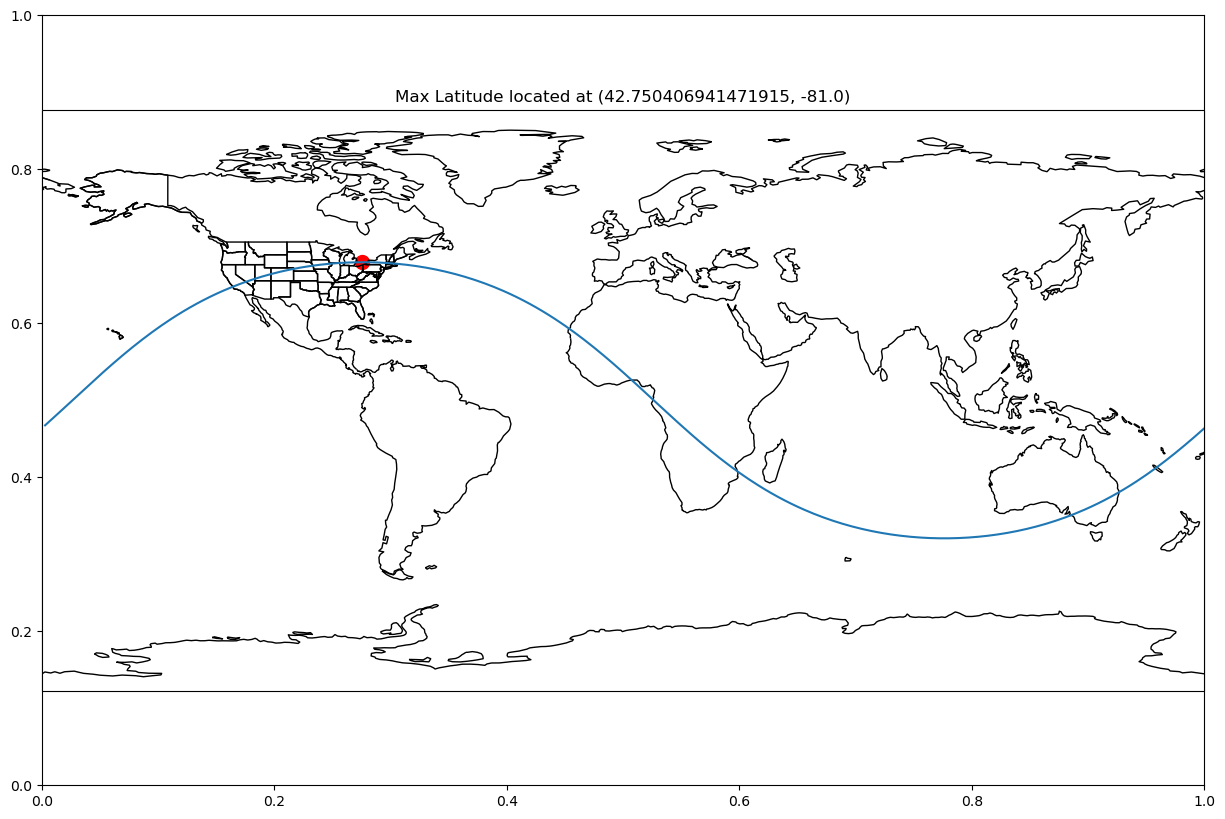

In [13]:
gc_lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=360)
max_lat_lon = max(gc_lat_lon, key=lambda x:x[0])
plot_coordinate_max_min(great_circle_pts=gc_lat_lon,
                            max_coord=max_lat_lon,
                            title=f"Max Latitude located at {max_lat_lon}")

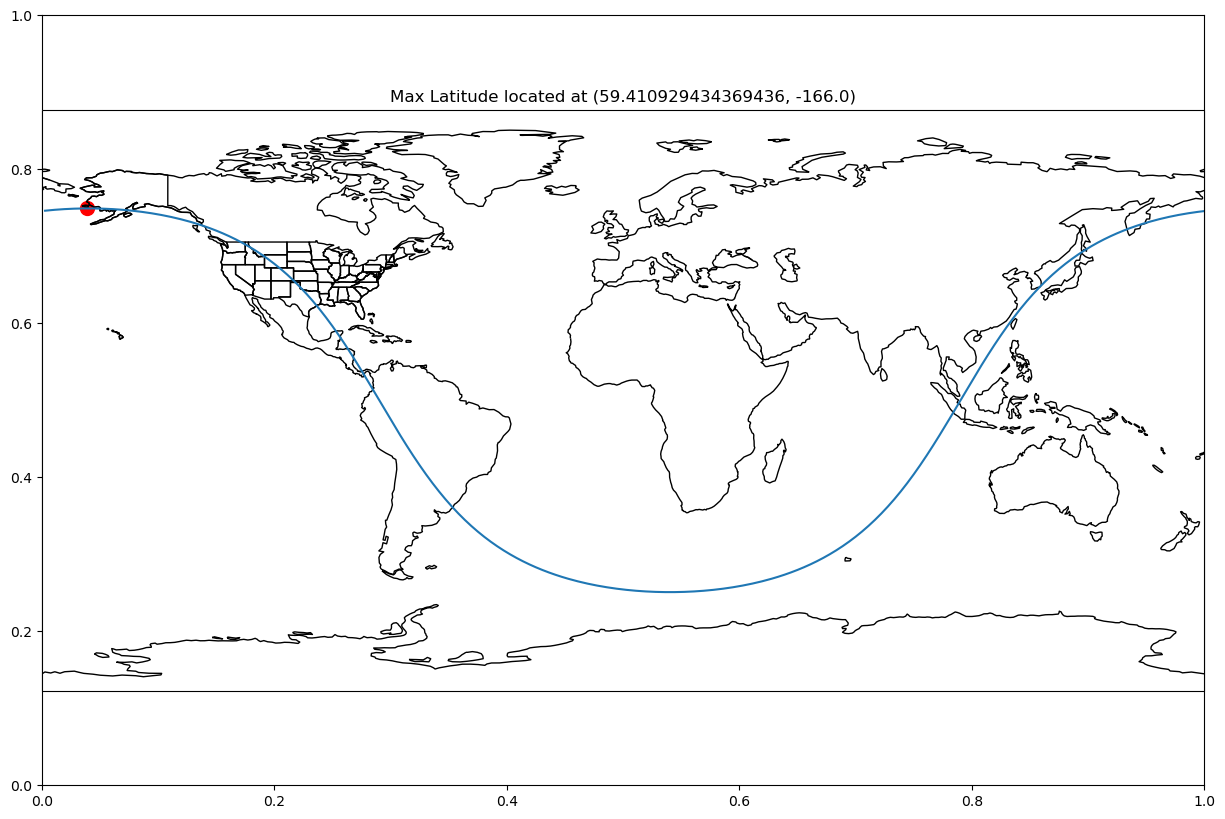

In [14]:
gc_lat_lon = generate_latitude_along_gc("boulder", "houston", number_of_lon_pts=360)
max_lat_lon = max(gc_lat_lon, key=lambda x:x[0])
plot_coordinate_max_min(great_circle_pts=gc_lat_lon,
                            max_coord=max_lat_lon,
                            title=f"Max Latitude located at {max_lat_lon}")

### Maximumn Latitude from Clairaut's Formula

[Clairaut's Formula](https://en.wikipedia.org/wiki/Clairaut%27s_relation_(differential_geometry)) (Clairaut's equation or Clairaut's relation) is a differential equation which defines the relationship between the latitude, φ, and the true course (bearing, θ) where:

$$sin(θ) * cos(φ) = \text{constant}$$

So, for any two points (A and B) along the great circle:

$$sin(θA) * cos(φA) = sin(θB) * cos(φB)$$

So, to solve for the maximum latitude the true course should be when 90 and 270 degrees on the unit sphere where for *any* bearing/latitude along the great circle:

$$\text{max latitude} = acos(|sin(θ) * cos(φ)|)$$

For the purpose of this example, we will use `pyproj` geodesic to determine the bearing based on a great circle arc, but consult previous sections if you want to determine bearing mathetically based on the unit sphere instead of the ellipsoid.

**Important Note**

Clairaut's Formula works from unit sphere, and as a result, is subject to errors (about 3%, about +/- 11 degrees).

- [Ed Williams: Clairaut's Formula](https://edwilliams.org/avform147.htm#Clairaut)

In [15]:
def clairaut_formula_max(start_point=None, end_point=None):
    geodesic = Geod(ellps="WGS84")
    fwd_bearing, _, _ =  geodesic.inv(location_df.loc[start_point, "longitude"],
                                      location_df.loc[start_point, "latitude"],
                                      location_df.loc[end_point, "longitude"],
                                      location_df.loc[end_point, "latitude"])
    # Clairaut
    start_lat = np.deg2rad(location_df.loc[start_point, "longitude"])
    max_lat = np.arccos(np.abs(np.sin(fwd_bearing) * np.cos(start_lat)))
    return np.rad2deg(max_lat)

In [16]:
max_lat = clairaut_formula_max("boulder", "boston")
print(f"Max latitude from Boulder to Boston: {max_lat}")

Max latitude from Boulder to Boston: 75.50718325253314


## Minimum Latitude on a Great Circle Path

Like finding maximum from a list of great circle path, the smallest latitude can be found by analysing the list for the smallest latitude point. The minimum also represnts the antipodal position on the globe from the maximum:

### Antipodal Point of Max is the Minimum

In [18]:
def antipodal(latitude=None, longitude=None):
    anti_lat = -1 * latitude
    if longitude > 0:
        anti_lon = longitude - 180
    else:
        anti_lon = longitude + 180
    return (anti_lat, anti_lon)

In [22]:
gc_lat_lon = generate_latitude_along_gc("boulder", "houston", number_of_lon_pts=360)
max_lat_lon = max(gc_lat_lon, key=lambda x:x[0])
print(f"Maximum Position: {max_lat_lon}")
print(f"Minimum (Antipodal) Position : {antipodal(max_lat_lon[0], max_lat_lon[1])}")

Maximum Position: (59.410929434369436, -166.0)
Minimum (Antipodal) Position : (-59.410929434369436, 14.0)


### Minimum Latitude along Great Circle Path

In [24]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=360)
print(f"Min Latitude (within 1 degree): {min(lat_lon, key=lambda x:x[0])}")

Min Latitude (within 1 degree): (-42.75040694147194, 99.0)


In [25]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=720)
print(f"Min Latitude (within 0.5 degree): {min(lat_lon, key=lambda x:x[0])}")

Min Latitude (within 0.5 degree): (-42.75138847183453, 99.5)


In [26]:
lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=1080)
print(f"Min Latitude (within 0.3 degree): {min(lat_lon, key=lambda x:x[0])}")

Min Latitude (within 0.3 degree): (-42.7513029587961, 99.33333333333331)


Let's give it a look:

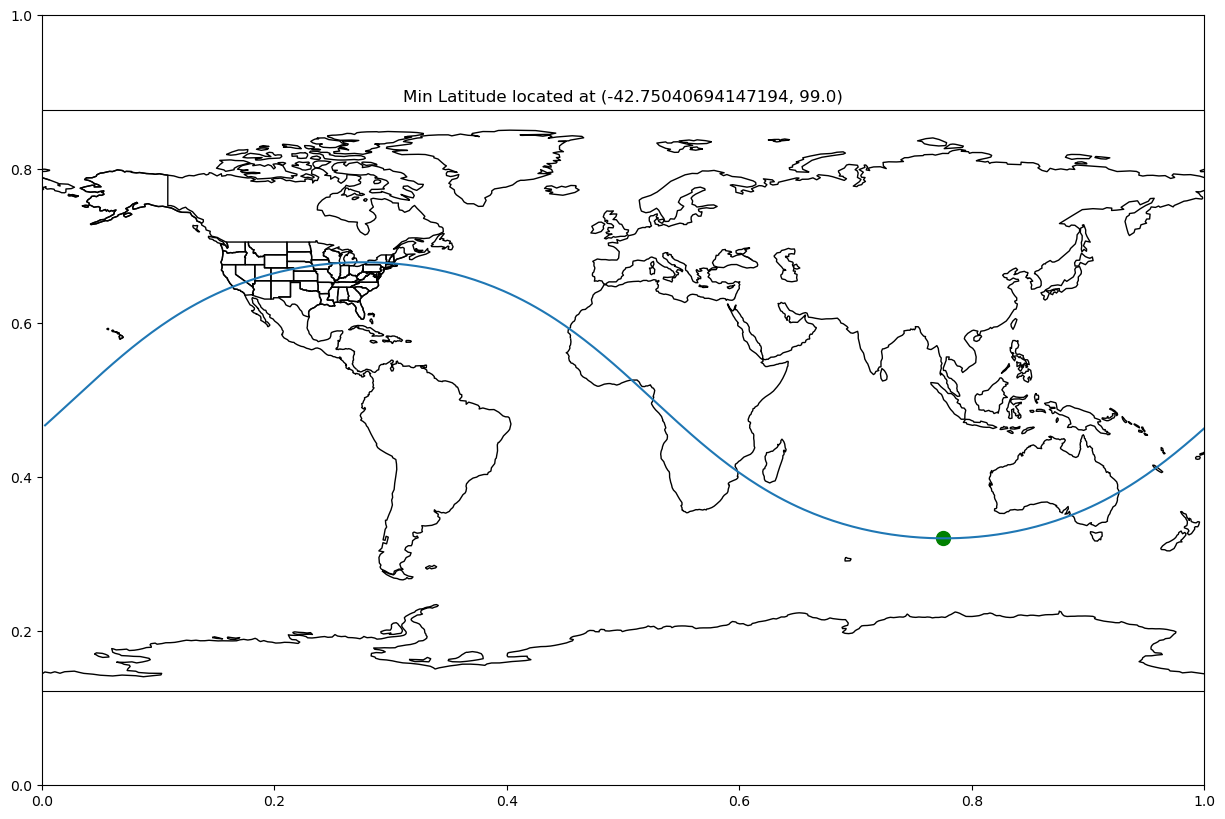

In [29]:
gc_lat_lon = generate_latitude_along_gc("boulder", "boston", number_of_lon_pts=360)
min_lat_lon = min(gc_lat_lon, key=lambda x:x[0])
plot_coordinate_max_min(great_circle_pts=gc_lat_lon,
                            min_coord=min_lat_lon,
                            title=f"Min Latitude located at {min_lat_lon}")

### Maximumn Latitude from Clairaut's Formula

To solve for the minimum, the true course should be when 0 and 180 degrees on the unit sphere where for *any* bearing/latitude along the great circle:

$$\text{min latitude} = asin(|sin(θ) * cos(φ)|)$$

The southernmost point is the antipode to the northernmost (max) latitude.

In [30]:
def clairaut_formula_min(start_point=None, end_point=None):
    geodesic = Geod(ellps="WGS84")
    fwd_bearing, _, _ =  geodesic.inv(location_df.loc[start_point, "longitude"],
                                      location_df.loc[start_point, "latitude"],
                                      location_df.loc[end_point, "longitude"],
                                      location_df.loc[end_point, "latitude"])
    # Clairaut Formula
    start_lat = np.deg2rad(location_df.loc[start_point, "longitude"])
    min_lat = np.arcsin(np.abs(np.cos(fwd_bearing) * np.sin(start_lat)))
    return np.rad2deg(min_lat)

In [31]:
min_lat = clairaut_formula_min("boulder", "boston")
print(f"Min latitude along great circle path from Boulder to Boston: {min_lat}")

Min latitude along great circle path from Boulder to Boston: 17.49699780715814


---

## Summary
iIn this notebook, we determined the position and coordinates for the maximum and minimum positions along the great circle arc as well as the position where a great circle crosses a specific parallel.

### What's next?

Next, we will work with multiple great circle paths to determine how and where they interest

## Resources and references

- [Aviation Formulary V1.47](https://edwilliams.org/avform147.htm)
- [Moveable Type Script](https://www.movable-type.co.uk/scripts/latlong.html)